In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import operator
from scipy.stats import zscore
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor

In [2]:
#Load dataset
df = pd.read_csv('Water_data_shuffled.csv')
df.head()

,c_total,Cd,Pb,Mod1,Mod2,Mod3
0,35,0.0,35.0,11833,372,123683
1,35,7.0,28.0,13823,153,124594
2,500,100.0,400.0,228329,3068,11172
3,100,20.0,80.0,59842,6878,82562
4,50,50.0,0.0,223508,23349,135933


The data is shuffled, so I have modified the dataframe here so that the replicas lie together and it is easy to do rest of the process

In [3]:
#I have shuffled back the data and taking the replicas together.
#group[1] is in dataframe. We concatenate it with the tuple of replicas. 
df_shuf = pd.concat( cols[1] for cols in df.groupby(['c_total','Cd','Pb'], sort=True) )
print (df_shuf.shape)
df_shuf.head()


(201, 6)


,c_total,Cd,Pb,Mod1,Mod2,Mod3
73,0,0.0,0.0,10812,120,98594
113,0,0.0,0.0,9945,119,72335
141,0,0.0,0.0,10786,117,82977
30,14,0.0,14.0,10566,108,136416
54,14,0.0,14.0,8495,120,131672


In [4]:
df_shuf=df_shuf.apply(zscore) #Applying the zscore here for the columns 
df_shuf.head()


,c_total,Cd,Pb,Mod1,Mod2,Mod3
73,-0.56001,-0.440936,-0.440936,-0.962827,-0.669732,0.094875
113,-0.56001,-0.440936,-0.440936,-0.971721,-0.669818,-0.335076
141,-0.56001,-0.440936,-0.440936,-0.963093,-0.669991,-0.160830
30,-0.55027,-0.440936,-0.425599,-0.965350,-0.670767,0.714153
54,-0.55027,-0.440936,-0.425599,-0.986596,-0.669732,0.636477


In [5]:
#Defining the c index function, which is a metric to check our regression output
def c_index(true_labels, predictions):
    """
    Calculate C-index
    """
    n = 0
    h_sum = 0
    for i in range(0, len(true_labels)):
        t = true_labels[i]
        p = predictions[i]
        for j in range(i+1, len(true_labels)):
            nt = true_labels[j]
            np = predictions[j]
            if t != nt:
                n += 1
                if (p < np and t < nt) or (p > np and t > nt):
                    h_sum += 1.0
                elif (p < np and t > nt) or (p > np and t < nt):
                    h_sum += 0
                elif p == np:
                    h_sum += 0.5
    return h_sum/float(n)

In [6]:
# testing c-index implementation
true_labels = [-1, 1, 1, -1, 1]
predictions = [0.60, 0.80, 0.75, 0.75, 0.70]
c_index(true_labels, predictions)

0.75

In [7]:
#Here I have used the KNN regression from SKearn combining with multioutput regression to get all the 3 predicted variables together.

def leave_replica_out_cv(dataset):

    #The dictionary will store the regression outputs for various values of k(1-10).
    CI={}
    for k in range(1,11):
        #3 rows are taken together so that one replica is taken at once.
        true_value=np.empty([0,3])
        predicted_value=np.empty([0,3])
        for i in range(0,len(dataset),3):  #Select each replica
            test=dataset[i:i+3]
            train=np.concatenate([dataset[0:i],dataset[i+3:]])
            y_test=test[:,0:3]
            x_test=test[:,3:6]
            y_train=train[:,0:3]
            x_train=train[:,3:6]
        
    
            #Calling, fitting and predicting from the model
            regr_multirf=MultiOutputRegressor(KNeighborsRegressor(n_neighbors=k,metric='euclidean'))
            regr_multirf.fit(x_train,y_train)
            predicted=regr_multirf.predict(x_test)

            true_value=np.concatenate([true_value, y_test])
            predicted_value=np.vstack((predicted_value, predicted))

        
        lst=[]
        #Loop through all the output columns(C_tot, Cd, and Pb)
        for j in range(len(true_value.T)):
            cols=c_index(true_value.T[j],predicted_value.T[j])
            lst.append(np.round(cols,3))
        CI[k]=lst
  
    return CI
        
    
        
        
        

In [8]:
k_with_CI=leave_replica_out_cv(df_shuf.values)
print(k_with_CI)

{1: [0.815, 0.741, 0.736], 2: [0.816, 0.746, 0.752], 3: [0.82, 0.735, 0.753], 4: [0.823, 0.722, 0.759], 5: [0.816, 0.721, 0.756], 6: [0.81, 0.714, 0.758], 7: [0.821, 0.719, 0.76], 8: [0.823, 0.715, 0.762], 9: [0.822, 0.705, 0.764], 10: [0.819, 0.697, 0.764]}


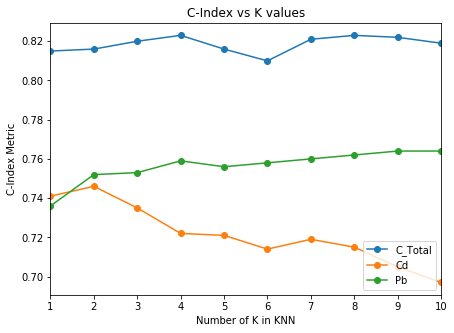

In [9]:
#Plotting the k values vs c index 
%matplotlib inline
import matplotlib.pyplot as plt
c_ind=np.array(list(k_with_CI.values())).T
plt.figure(figsize=(7,5))
plt.plot(k_with_CI.keys(),c_ind[0],label='C_Total',marker='o')
plt.plot(k_with_CI.keys(),c_ind[1],label='Cd',marker='o')
plt.plot(k_with_CI.keys(),c_ind[2],label='Pb',marker='o')
plt.xlabel('Number of K in KNN')
plt.ylabel('C-Index Metric')
plt.xlim([1,10])
plt.legend(loc=4)
plt.title('C-Index vs K values')
plt.show()

#Conclusion:
As far as I understood, the previous data was shuffled so I was not able to take the replica together, unless I shuffled it back. 
Then I have done the leave-replica-out cross validation with the KNN algorithm and plotted the results obtained. 